In [1]:

import plotly.express as px
import matplotlib.pyplot as plt
from funcoes import *
import seaborn as sns
import scipy.stats as st
from scipy.stats import gamma, lognorm
from scipy import stats as st
import statsmodels.api as sm
from scipy.stats import norm




In [2]:
pasta = r"C:\Users\Dell\OneDrive\Norm\Norm"

In [3]:
inventario_macae = carregar_arquivo(
    "INVENTÁRIO_REJEITOS_NORM_MACAE_30_07_25",
    pasta=pasta,
    sheet_name='Base de dados',           # ou o nome da aba, se precisar
    search_subdirs=True,    # vasculha subpastas
    match_mode="fuzzy"      # aceita variações no nome
)

Arquivo 'INVENTÁRIO_REJEITOS_NORM_MACAE_30_07_25.xlsx' carregado com sucesso de: C:\Users\Dell\OneDrive\Norm\Norm


# Tratamento de dados INVENTARIO

In [4]:
#remover colunas vazias

inventario_macae = inventario_macae.dropna(axis=1, how='all')


In [5]:
map_residuos = {
    'BORRA CAT.II':'BORRA CAT II',
    'BORRA CAT.I':'BORRA CAT I'
}

inventario_macae['TIPO DE RESÍDUO'] = (inventario_macae['TIPO DE RESÍDUO'].replace(map_residuos).str.upper().str.strip())


In [6]:
# Criar AnoMes no formato YYYY-MM
inventario_macae["AnoMes"] = inventario_macae["ANO DE GERAÇÃO (DATA SIGRE)"].dt.to_period("M").astype(str)

In [7]:
residuos_por_galpao = (inventario_macae.groupby(['DEPÓSITO', 'TIPO DE RESÍDUO'])['MASSA DO VOLUME (kg)'].sum().reset_index())

In [8]:
residuos_por_tipo = (inventario_macae.groupby(['AnoMes','TIPO DE RESÍDUO'])['MASSA DO VOLUME (kg)']).sum().reset_index()

In [9]:
pivot_residuos = residuos_por_galpao.pivot_table(
    index="DEPÓSITO",
    columns="TIPO DE RESÍDUO",
    values="MASSA DO VOLUME (kg)",
    aggfunc="sum",
    fill_value=0
)

In [12]:
pivot_residuos_tipo = residuos_por_tipo.pivot_table(
    index="AnoMes",
    columns="TIPO DE RESÍDUO",
    values="MASSA DO VOLUME (kg)",
    aggfunc="sum",
    fill_value=0)

In [14]:



fig = go.Figure()

for col in pivot_residuos_tipo.columns:
    if col != 'AnoMes':  # ignora a coluna de datas
        fig.add_trace(go.Scatter(
            x=pivot_residuos_tipo.index,
            y=pivot_residuos_tipo[col],
            mode='lines+markers',
            name=col   # nome da coluna vira legenda (Resíduo A, B, C…)
        ))

fig.update_layout(
    title='Série temporal por resíduo',
    xaxis_title='Data',
    yaxis_title='Massa de resíduo (kg)'
)

fig.show()


In [ ]:
pivot_mensal_tipo = residuos_por_tipo.pivot_table(
    index='AnoMes',
    columns='TIPO DE RESÍDUO',
    values='MASSA DO VOLUME (kg)',
    aggfunc='sum',
    fill_value=0

)

In [ ]:
pivot_pct = pivot_residuos.div(pivot_residuos.sum(axis=1), axis=0) * 100


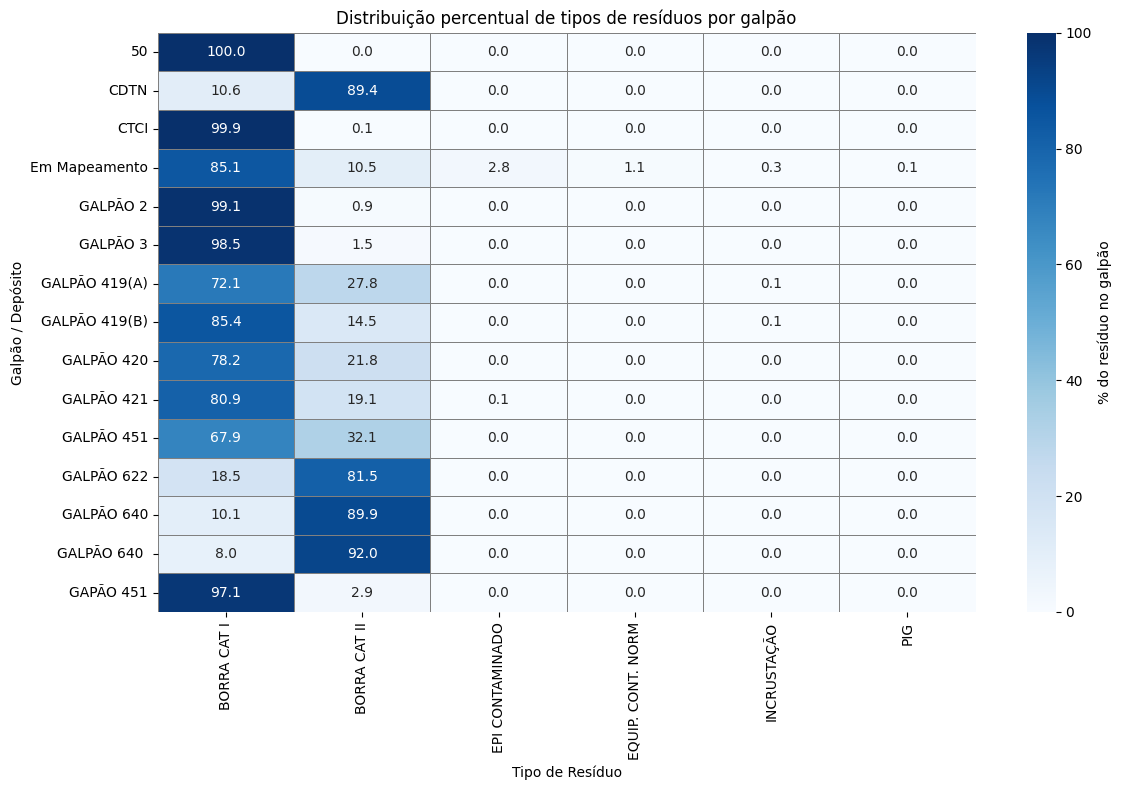

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(
    pivot_pct,
    cmap="Blues",
    annot=True,
    fmt=".1f",
    cbar_kws={'label': '% do resíduo no galpão'},
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Distribuição percentual de tipos de resíduos por galpão")
plt.xlabel("Tipo de Resíduo")
plt.ylabel("Galpão / Depósito")
plt.tight_layout()
plt.show()


In [ ]:
top_locais = inventario_macae['LOCAL DA GERAÇÃO'].value_counts().head(10)

In [ ]:
top_quantidades = (inventario_macae.groupby('LOCAL DA GERAÇÃO')['MASSA DO VOLUME (kg)'].sum().sort_values(ascending=False).head(10))

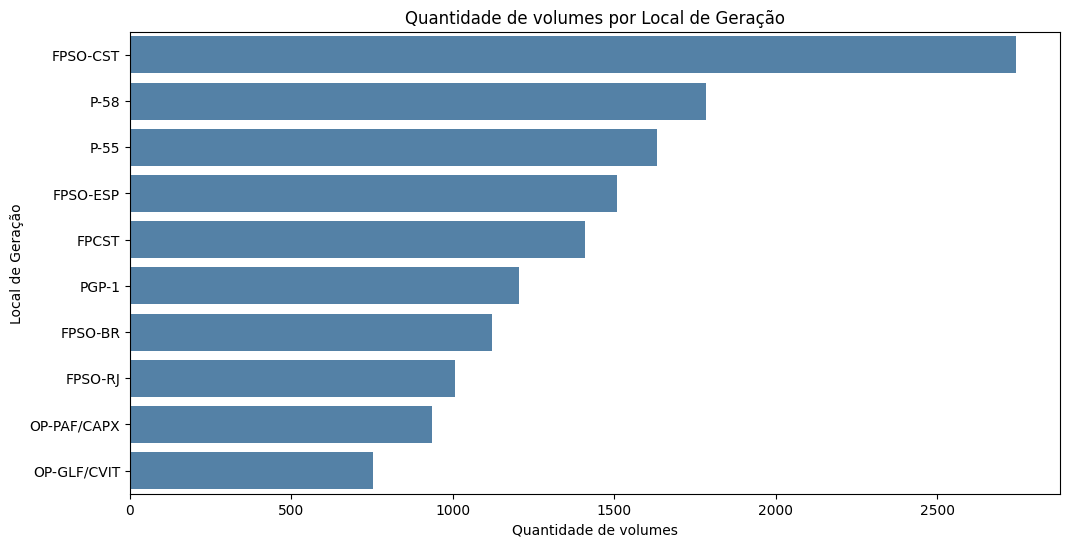

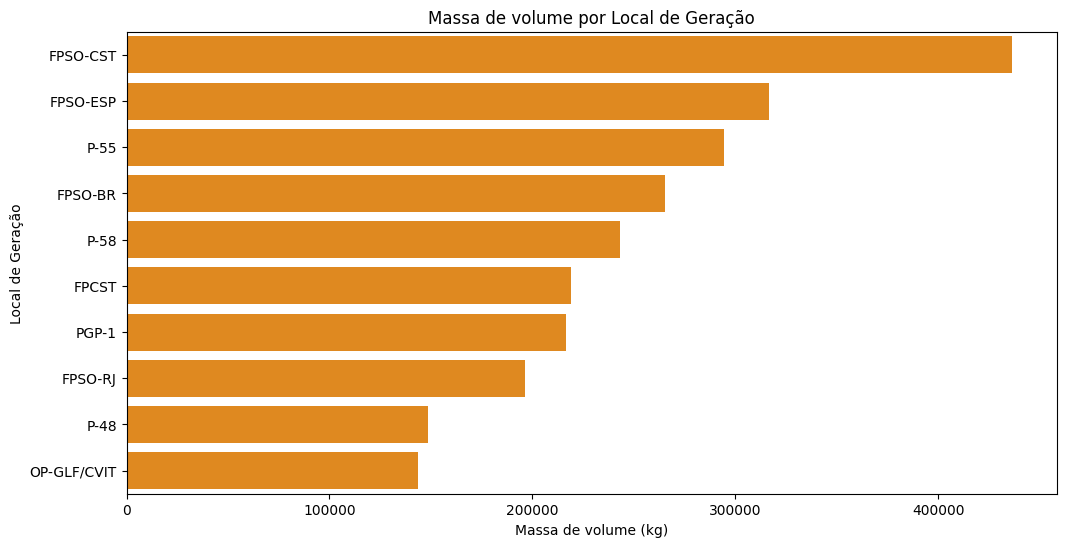

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_locais.values, y=top_locais.index, color='steelblue')
plt.title('Quantidade de volumes por Local de Geração')
plt.ylabel('Local de Geração')
plt.xlabel('Quantidade de volumes')

plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=top_quantidades.values, y=top_quantidades.index, color='darkorange')
plt.title('Massa de volume por Local de Geração')
plt.ylabel('Local de Geração')
plt.xlabel('Massa de volume (kg)')
plt.show()

In [ ]:
# Criar AnoMes no formato YYYY-MM
inventario_macae["AnoMes"] = inventario_macae["ANO DE GERAÇÃO (DATA SIGRE)"].dt.to_period("M").astype(str)

# 1) Soma mensal por depósito + tipo de resíduo
soma_mensal = (
    inventario_macae
    .groupby(["AnoMes","TIPO DE RESÍDUO"], as_index=False)["MASSA DO VOLUME (kg)"]
    .sum()
    .reset_index(drop=True)   # garante DataFrame
    .sort_values(["TIPO DE RESÍDUO","AnoMes"])   
)

# 2) Acumulado correto por depósito + tipo
soma_mensal["Acumulado (kg)"] = (
    soma_mensal.groupby(["TIPO DE RESÍDUO"])["MASSA DO VOLUME (kg)"].cumsum()
)

# 3) Pivot para formato largo
acumulado_residuo = (
    soma_mensal
    .pivot_table(
        index=["AnoMes"],
        columns="TIPO DE RESÍDUO",
        values="Acumulado (kg)",
        aggfunc="last",
        fill_value=0
    )
    .reset_index()
)

# 4) Renomear colunas para deixar claro
acumulado_residuo = acumulado_residuo.rename(
    columns=lambda x: f"Acumulado {x}" if x not in ["AnoMes"] else x
)

print(acumulado_residuo.head())


TIPO DE RESÍDUO   AnoMes  Acumulado BORRA CAT I  Acumulado BORRA CAT II  \
0                2002-01                 2541.0                  6929.5   
1                2002-10                    0.0                  7119.5   
2                2002-12                 2841.0                  9449.0   
3                2003-01                 4331.0                 11663.0   
4                2003-07                 4481.0                     0.0   

TIPO DE RESÍDUO  Acumulado EPI CONTAMINADO  Acumulado EQUIP. CONT. NORM  \
0                                      0.0                          0.0   
1                                      0.0                          0.0   
2                                      0.0                          0.0   
3                                    250.0                          0.0   
4                                      0.0                          0.0   

TIPO DE RESÍDUO  Acumulado EQUIPAMENTOS  Acumulado INCRUSTAÇÃO  Acumulado PIG  
0                 

In [ ]:


# deposito = "FPSO-RJ"
# dados = acumulado_residuo[acumulado_residuo["LOCAL DA GERAÇÃO"] == deposito]

# # Transformar dados de wide → long
# dados_long = dados.melt(
#     id_vars=["AnoMes", "LOCAL DA GERAÇÃO"],
#     value_vars=[c for c in dados.columns if c.startswith("Acumulado")],
#     var_name="Tipo de Resíduo",
#     value_name="Acumulado (kg)"
# )

# # Deixar o nome mais limpo
# dados_long["Tipo de Resíduo"] = dados_long["Tipo de Resíduo"].str.replace("Acumulado ", "")

# # Gráfico interativo
# fig = px.line(
#     dados_long,
#     x="AnoMes",
#     y="Acumulado (kg)",
#     color="Tipo de Resíduo",
#     title=f"Evolução acumulada de resíduos - {deposito}"
# )

# fig.update_traces(mode='markers+lines')
# # Ajustes visuais
# fig.update_layout(
#     xaxis=dict(tickangle=-45),
#     legend=dict(title="Clique para ligar/desligar resíduos")
# )

# fig.show()


# Acumulado no ano

In [ ]:
# análise para descobrir anos de descomissionamento de galpões

def modelo_somatorio(df):
    df['Ano'] = pd.to_datetime(df['ANO DE GERAÇÃO (DATA SIGRE)'], errors='coerce').dt.year.astype('Int64')
    #somar por ano toda a massa
    somatorio_ano = df.groupby(['Ano', 'TIPO DE RESÍDUO'])['MASSA DO VOLUME (kg)'].sum().reset_index()
    #acumulado por tipo de resíduo
    somatorio_ano['Acumulado (kg)'] = somatorio_ano.groupby('TIPO DE RESÍDUO')['MASSA DO VOLUME (kg)'].cumsum()

    somatorio_ano['Crescimento (kg/ano)'] = somatorio_ano.groupby('TIPO DE RESÍDUO')['Acumulado (kg)'].diff()
    
    #plotar cada residuo no tempo

    fig = go.Figure()
    for residuo in somatorio_ano['TIPO DE RESÍDUO'].unique():
        df_residuo = somatorio_ano[somatorio_ano['TIPO DE RESÍDUO'] == residuo]
        fig.add_trace(go.Scatter(x=df_residuo['Ano'], y=df_residuo['Acumulado (kg)'], mode='lines+markers', name=residuo))
    fig.update_layout(title='Evolução Acumulada de por tipo de resíduo', xaxis_title='Ano', yaxis_title='Acumulado (kg)')
    fig.show()
    return somatorio_ano





In [ ]:
somatorio_ano =modelo_somatorio(inventario_macae)

# Taxa de crescimento da massa de residuos em kg

In [ ]:


# Resumo estatístico por resíduo
resumo = somatorio_ano.groupby('TIPO DE RESÍDUO').agg(
    Massa_inicial=('Acumulado (kg)', 'first'),
    Massa_final=('Acumulado (kg)', 'last'),
    Crescimento_medio=('Crescimento (kg/ano)', 'mean'),
    Crescimento_max=('Crescimento (kg/ano)', 'max')
).reset_index()

print(resumo)

# Plotar velocidade de crescimento (delta ano a ano)
import plotly.express as px
fig = px.line(
    somatorio_ano, 
    x='Ano', y='Crescimento (kg/ano)', 
    color='TIPO DE RESÍDUO',
    title='Taxa crescimento Anual por Resíduo',
    range_x= [somatorio_ano['Ano'].min(), somatorio_ano['Ano'].max()]
)
fig.show()


     TIPO DE RESÍDUO  Massa_inicial  Massa_final  Crescimento_medio  \
0        BORRA CAT I       2841.000  3137114.790      142466.990455   
1       BORRA CAT II       9449.000   789609.300       33920.013043   
2    EPI CONTAMINADO        250.000     4107.780         257.185333   
3  EQUIP. CONT. NORM         40.000     1040.000         250.000000   
4       EQUIPAMENTOS        118.000      118.000                NaN   
5        INCRUSTAÇÃO      79510.385   259640.285       18012.990000   
6                PIG        130.000      130.000                NaN   

   Crescimento_max  
0        546458.75  
1        142892.00  
2           741.28  
3           765.00  
4              NaN  
5         91164.70  
6              NaN  


# Gráfico fitted value

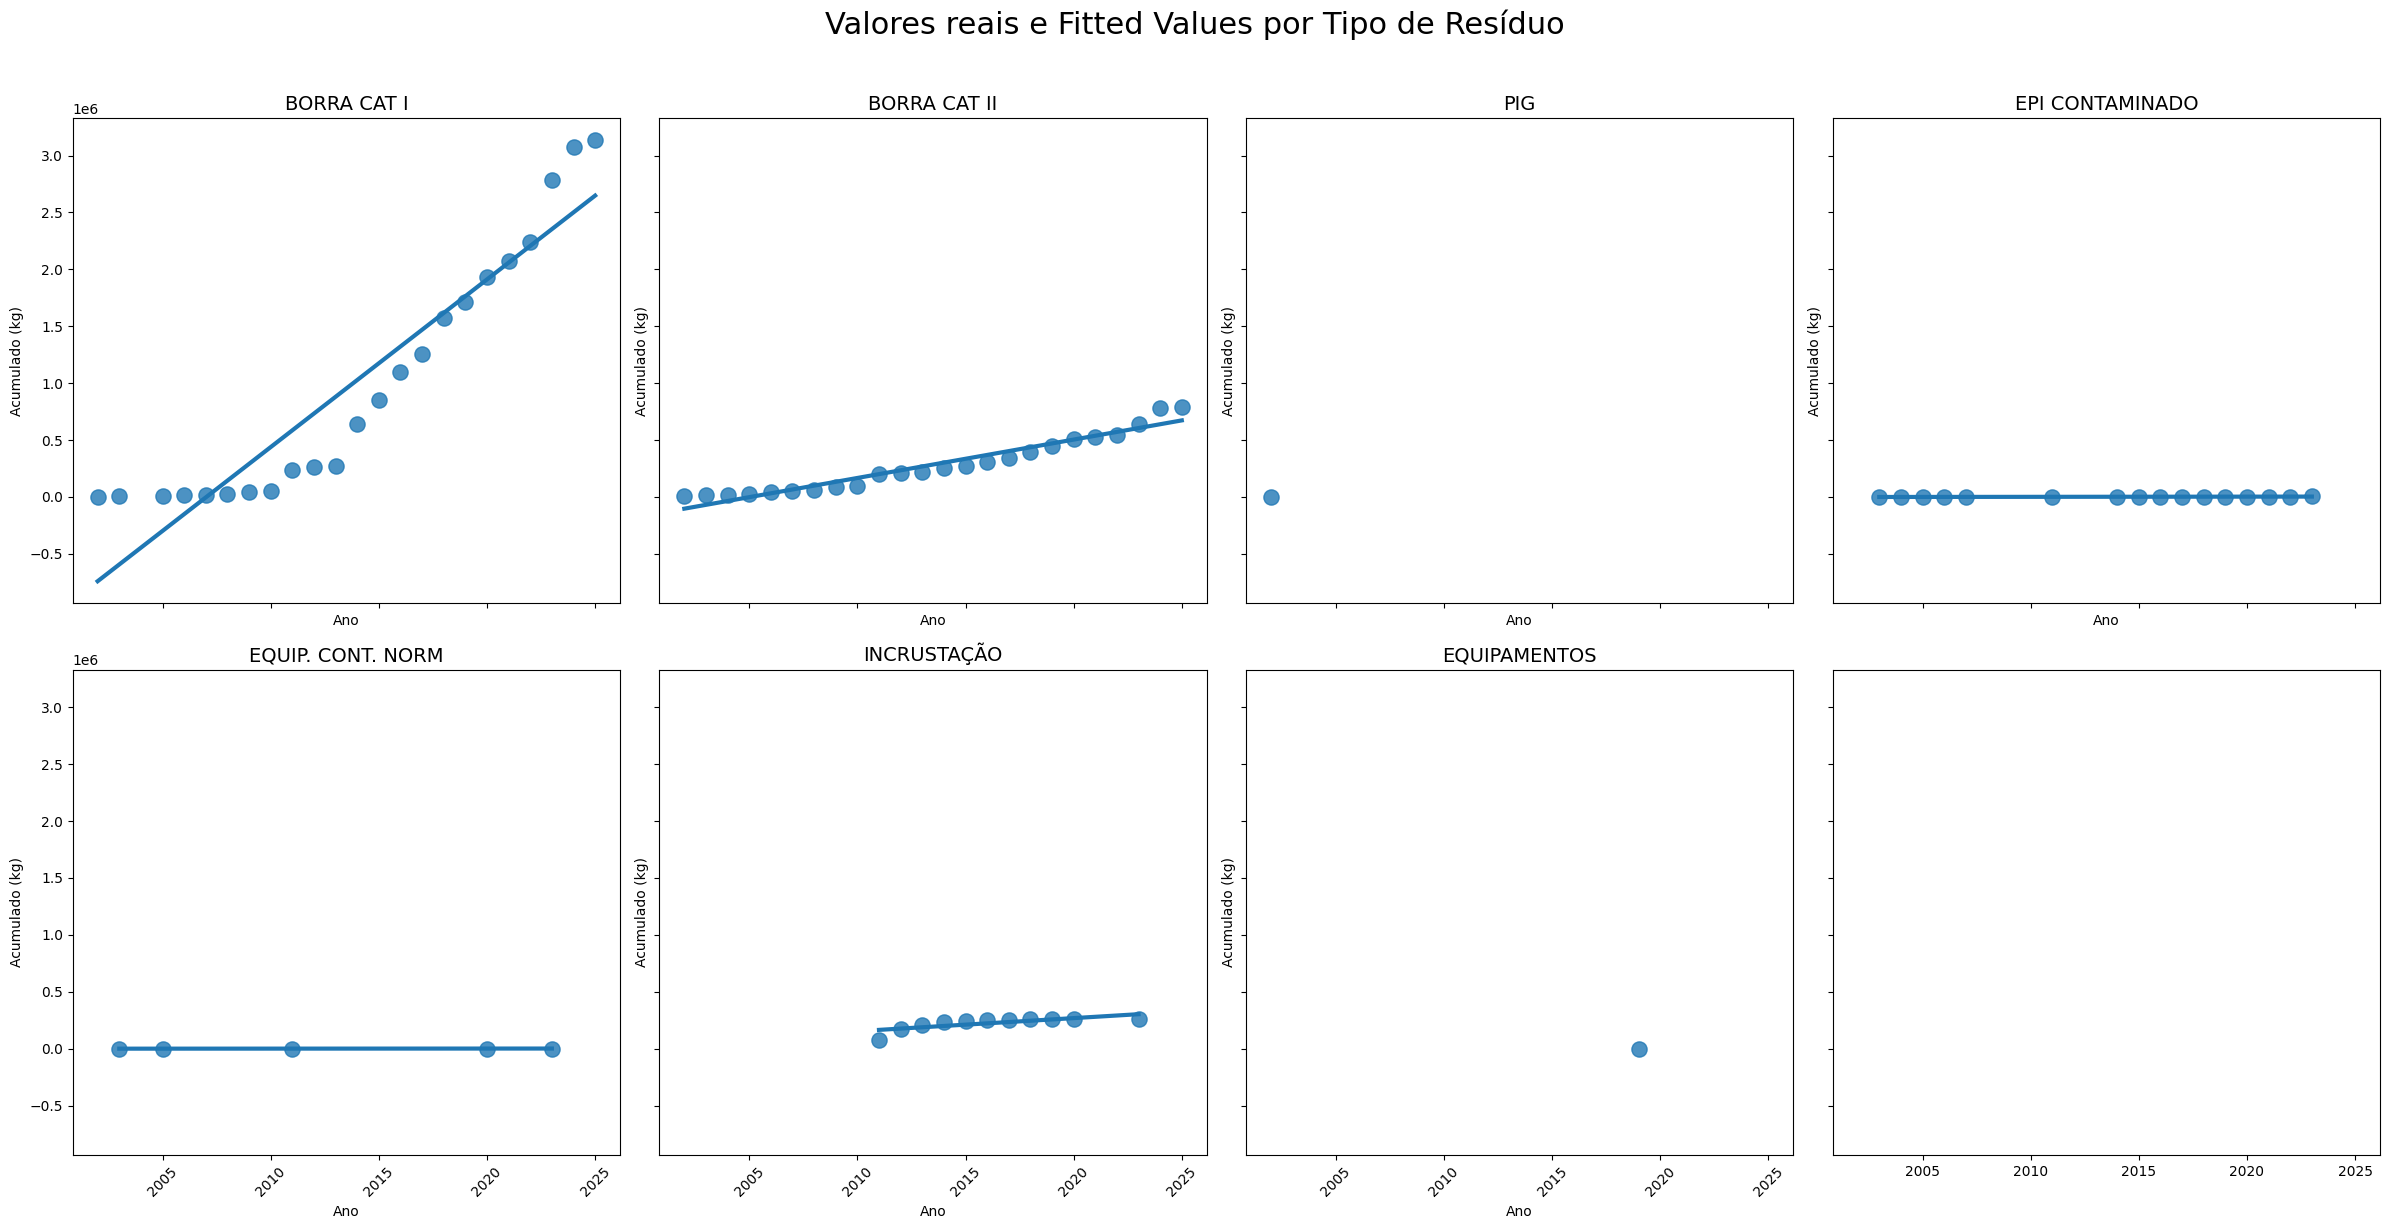

In [ ]:




# cria 2 linhas x 4 colunas de subplots
fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharex=True, sharey=True)

# achata o array 2D em 1D
axes = axes.flatten()

# loop para cada resíduo
for i, residuo in enumerate(somatorio_ano['TIPO DE RESÍDUO'].unique()):
    df_residuo = somatorio_ano[somatorio_ano['TIPO DE RESÍDUO'] == residuo]
    
    sns.regplot(
        data=df_residuo,
        x='Ano', 
        y='Acumulado (kg)', 
        marker='o', 
        ci=False,
        scatter_kws={'alpha':0.8, 's':120},
        line_kws={'linewidth':3},
        ax=axes[i]   # aqui é um único Axes válido
    )
    
    axes[i].set_title(residuo, fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# remove subplot vazio (vai sobrar 1, porque são 8 espaços e só 7 resíduos)
for j in range(len(residuo), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Valores reais e Fitted Values por Tipo de Resíduo', fontsize=22, y=1.02)
plt.tight_layout()
plt.show()



# Projeção da tendência dos dados

In [19]:
dfs_residuos, resumo, proj = projetar_futuro(
    inventario_macae,
    anos_futuros=3,
    residuo_alvo="BORRA CAT I",
    tipo_modelo=    'piece'
)


c:\Users\Dell\OneDrive\Norm\Norm\funcoes.py:701: OptimizeWarning:

Covariance of the parameters could not be estimated



PIG: poucos dados
EQUIPAMENTOS: poucos dados


c:\Users\Dell\OneDrive\Norm\Norm\funcoes.py:701: OptimizeWarning:

Covariance of the parameters could not be estimated

c:\Users\Dell\OneDrive\Norm\Norm\funcoes.py:701: OptimizeWarning:

Covariance of the parameters could not be estimated

c:\Users\Dell\OneDrive\Norm\Norm\funcoes.py:701: OptimizeWarning:

Covariance of the parameters could not be estimated

c:\Users\Dell\OneDrive\Norm\Norm\funcoes.py:701: OptimizeWarning:

Covariance of the parameters could not be estimated

